In [195]:
import numpy as np
from SimPEG.electromagnetics import natural_source as nsem
from SimPEG import maps
import matplotlib.pyplot as plt
import matplotlib
from discretize import TensorMesh
from SimPEG import (
    maps,
    data,
    data_misfit,
    regularization,
    optimization,
    inverse_problem,
    inversion,
    directives,
    utils,
)
matplotlib.rcParams['font.size'] = 14
from pymatsolver import Pardiso
from matplotlib.colors import LogNorm

In [196]:
from pyMKL import mkl_set_num_threads

In [197]:
mkl_set_num_threads(1)

In [198]:
from geoana.em.fdem import skin_depth

In [199]:
from discretize import utils as dis_utils

In [200]:
dz = skin_depth(100, 1e-2) / 5.
print (dz)
csz = 100.

100.65842418157608


In [201]:
print (skin_depth(1e-2, 1e-3) / 1e3 * 4)

636.6197721943012


In [202]:
hz_down = csz*1.2**np.arange(40)[::-1]
npadz = 15
pfz = 1.5
hz_up = [(csz, npadz, pfz)]
hz = np.r_[hz_down, dis_utils.meshTensor(hz_up)]
print (hz.sum() / 1e3)

865.4539510988002


In [203]:
csx = 400
ncx = 54
npadx = 15
pfx = 1.5
hx = [(csx, npadx, -pfx), (csx, ncx), (csx, npadx, pfx)]
dis_utils.meshTensor(hx)[:npadx].sum() / 1e3

524.2726684570313

In [251]:
ncx * csx

21600

In [252]:
mesh = TensorMesh([hx, hz])
mesh.origin = np.r_[-mesh.hx.sum()/2, -hz_down.sum()]

sigma_back = 1e-2
sigma_block_left = 1e0
sigma_block_right = 1e-4
sigma_air = 1e-8

cells = mesh.cell_centers
sigma = np.ones(mesh.n_cells) * sigma_back
blk_ind_left = utils.model_builder.getIndicesBlock(np.r_[-7000, -2500], np.r_[-5000, -5000], cells)
blk_ind_right = utils.model_builder.getIndicesBlock(np.r_[+5000, -2500], np.r_[7000, -5000], cells)
layer_ind = np.logical_and(cells[:,1]<-5000, cells[:,1]>-5500)
sigma[blk_ind_left] = sigma_block_left
sigma[blk_ind_right] = sigma_block_right
sigma[cells[:, -1] >= 0] = sigma_air
frequencies = np.logspace(-1, 1, 6)

rx_locs = np.c_[np.linspace(-10000, 10000, 21), np.zeros(21)]

In [253]:
(cells[:, -1] >= 0).sum()

1260

In [254]:
# fig, ax = plt.subplots(1,1, figsize=(10, 10))
# mesh.plot_image(sigma, grid=True, ax=ax, pcolor_opts={'norm':LogNorm(), 'cmap':'turbo'})
# ax.plot(rx_locs[:,0], rx_locs[:,1], '.')
# ax.set_aspect(1)

In [255]:
hz_down.sum()

734385.7839845424

## Extract core mesh

In [256]:
xmin = mesh.x0[0] + mesh.hx[:npadx].sum()
xmax = mesh.x0[0] +  mesh.hx[:npadx+ncx].sum()
zmin = -13000
zmax = 0

In [257]:
from discretize import utils as dis_utils
xylim=np.array([[xmin, xmax],[zmin, zmax]])
inds_core, mesh_core = dis_utils.extract_core_mesh(xylim, mesh)

(-1000.0, 1000.0)

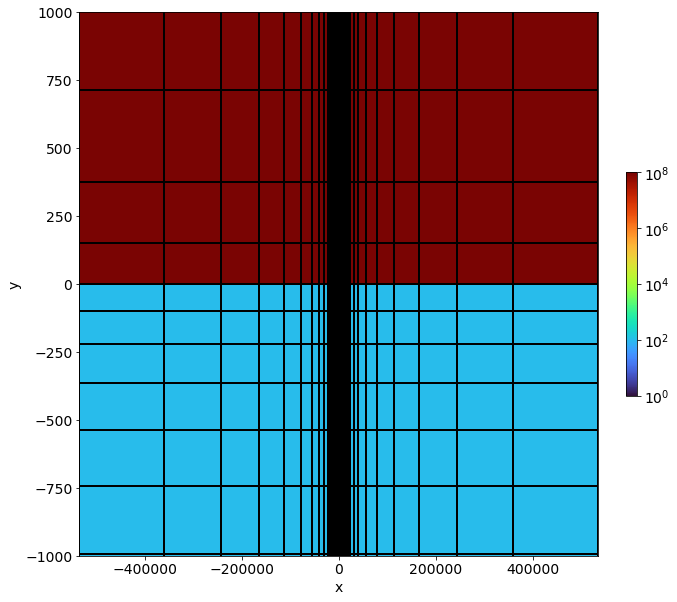

In [258]:
fig, ax = plt.subplots(1,1, figsize=(10, 10))
out = mesh.plot_image(1./sigma, grid=True, ax=ax, pcolor_opts={'norm':LogNorm(), 'cmap':'turbo'})
plt.colorbar(out[0], fraction=0.02)
# ax.plot(rx_locs[:,0], rx_locs[:,1], '.')
# ax.set_aspect(20)
ax.set_ylim(-1000, 1000)

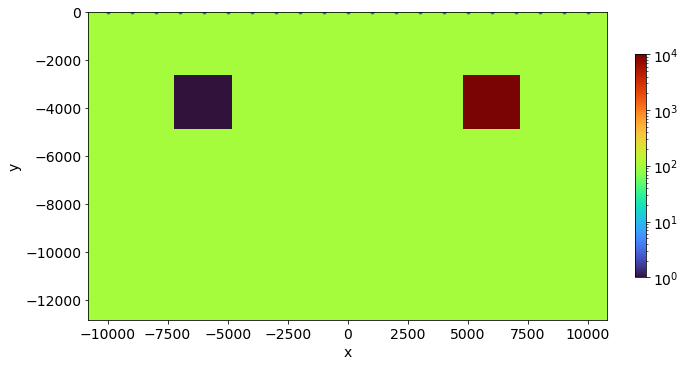

In [259]:
fig, ax = plt.subplots(1,1, figsize=(10, 10))
out = mesh_core.plot_image(1./sigma[inds_core], grid=False, ax=ax, pcolor_opts={'norm':LogNorm(), 'cmap':'turbo'})
plt.colorbar(out[0], fraction=0.02)
ax.plot(rx_locs[:,0], rx_locs[:,1], '.')
ax.set_aspect(1)

In [260]:
# simulation class for TE mode
rx_list_te = [
    nsem.receivers.PointNaturalSource(
        rx_locs, orientation="xy", component="apparent_resistivity"
    ),
    nsem.receivers.PointNaturalSource(
        rx_locs, orientation="xy", component="phase"
    ),
]
src_list_te = [nsem.sources.Planewave(rx_list_te, frequency=f) for f in frequencies]
survey_te = nsem.Survey(src_list_te)

ind_active = sigma != sigma_air
act_map = maps.InjectActiveCells(mesh, ind_active, np.log(1e-8))
exp_map = maps.ExpMap(mesh=mesh)
sigma_map = exp_map * act_map
sim_te= nsem.simulation.Simulation2DElectricField(
    mesh,
    survey=survey_te,
    sigmaMap=sigma_map,
    solver=Pardiso,
)

In [261]:
np.diff(rx_locs[:,0])

array([1000., 1000., 1000., 1000., 1000., 1000., 1000., 1000., 1000.,
       1000., 1000., 1000., 1000., 1000., 1000., 1000., 1000., 1000.,
       1000., 1000.])

In [262]:
# simulation class for TE mode
rx_list_tm = [
    nsem.receivers.PointNaturalSource(
        rx_locs, orientation="yx", component="apparent_resistivity"
    ),
    nsem.receivers.PointNaturalSource(
        rx_locs, orientation="yx", component="phase"
    ),
]
src_list_tm = [nsem.sources.Planewave(rx_list_tm, frequency=f) for f in frequencies]
survey_tm = nsem.Survey(src_list_tm)

sim_tm = nsem.simulation.Simulation2DMagneticField(
    mesh,
    survey=survey_tm,
    sigmaMap=sigma_map,
    solver=Pardiso,
)

In [263]:
n_rx_loc = rx_locs.shape[0]
n_freq = len(frequencies)

In [264]:
m = np.log(sigma[ind_active])

In [265]:
pred_te = sim_te.dpred(m)
pred_tm = sim_tm.dpred(m)
PRED_te = pred_te.reshape((n_freq, 2, n_rx_loc))
PRED_tm = pred_tm.reshape((n_freq, 2, n_rx_loc))

rho_app_te = PRED_te[:,0,:]
rho_app_tm = PRED_tm[:,0,:]

phase_te = PRED_te[:,1,:]
phase_tm = PRED_tm[:,1,:]

In [266]:
# f_te = sim_te.fields(m)`

In [267]:
# mesh.plot_image(f_te[src_list_te[0], 'e'].real, v_type='E', view='vec')

In [268]:
rerr_rho_app = 0.02
floor_phase = 2
std_te = np.zeros_like(PRED_te)
std_te[:,0,:] = abs(rho_app_te) * rerr_rho_app
std_te[:,1,:] = np.ones_like(phase_te) * floor_phase
std_te = std_te.flatten()

std_tm = np.zeros_like(PRED_tm)
std_tm[:,0,:] = abs(rho_app_tm) * rerr_rho_app
std_tm[:,1,:] = np.ones_like(phase_tm) * floor_phase
std_tm = std_tm.flatten()

In [269]:
nrx, nfreq = phase_te.shape

In [270]:
noise_te = np.zeros_like(PRED_te)
noise_te[:,0,:] = abs(rho_app_te) * rerr_rho_app * np.random.randn(nrx, nfreq)
noise_te[:,1,:] = np.ones_like(phase_te) * floor_phase * np.random.randn(nrx, nfreq)
noise_te = noise_te.flatten()

noise_tm = np.zeros_like(PRED_tm)
noise_tm[:,0,:] = abs(rho_app_tm) * rerr_rho_app * np.random.randn(nrx, nfreq)
noise_tm[:,1,:] = np.ones_like(phase_tm) * floor_phase * np.random.randn(nrx, nfreq)
noise_tm = noise_tm.flatten()

In [271]:
dobs_te = pred_te + noise_te
dobs_tm = pred_tm + noise_tm

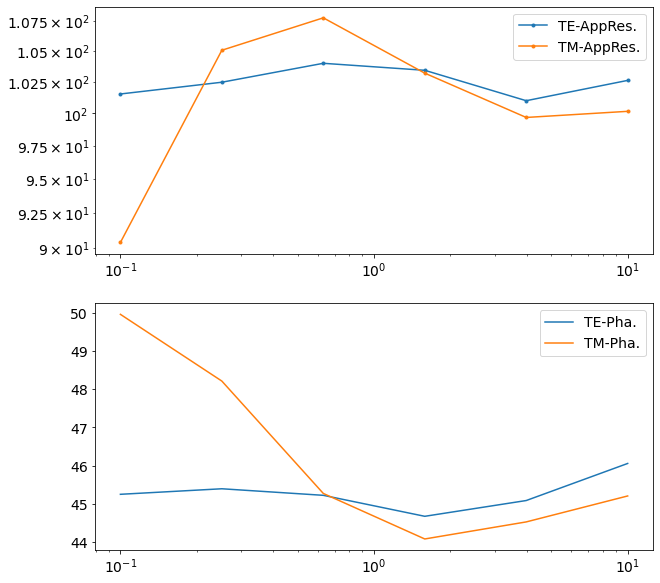

In [272]:
i_sounding = 20
fig, axs = plt.subplots(2, 1, figsize=(10, 10))
ax1, ax2 = axs
ax1.loglog(frequencies, rho_app_te[:,i_sounding], '.-', label='TE-AppRes.')
ax1.loglog(frequencies, rho_app_tm[:,i_sounding], '.-', label='TM-AppRes.')
ax1.legend()
# ax1.set_ylim(10, 1e4)

ax2.semilogx(frequencies, phase_te[:,i_sounding]+180, label='TE-Pha.')
ax2.semilogx(frequencies, phase_tm[:,i_sounding], label='TM-Pha.')
# ax2.set_ylim(0, 90)
ax2.legend()

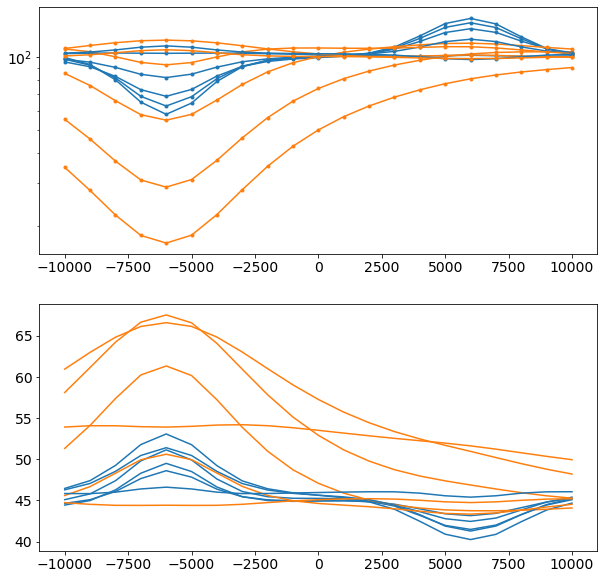

In [273]:
i_freq = -1
fig, axs = plt.subplots(2, 1, figsize=(10, 10))
for i_freq in range(len(frequencies)):
    ax1, ax2 = axs
    ax1.semilogy(rx_locs[:,0], rho_app_te[i_freq,:], '.-', label='TE-AppRes.', color='C0')
    ax1.semilogy(rx_locs[:,0], rho_app_tm[i_freq,:], '.-', label='TM-AppRes.', color='C1')
#     ax1.legend()

    ax2.plot(rx_locs[:,0], phase_te[i_freq,:]+180, label='TE-Pha.', color='C0')
    ax2.plot(rx_locs[:,0], phase_tm[i_freq,:], label='TM-Pha.', color='C1')
#     ax2.legend()

In [274]:
sigma_map * m

array([1.e-02, 1.e-02, 1.e-02, ..., 1.e-08, 1.e-08, 1.e-08])

In [275]:
te_data_object = data.Data(survey_te, dobs=dobs_te, standard_deviation=std_te) 
tm_data_object = data.Data(survey_tm, dobs=dobs_tm, standard_deviation=std_tm) 

In [276]:
dmis_te = data_misfit.L2DataMisfit(data=te_data_object, simulation=sim_te)
dmis_tm = data_misfit.L2DataMisfit(data=tm_data_object, simulation=sim_tm)

In [277]:
m0 = np.ones(ind_active.sum()) * np.log(1./50.)

In [ ]:
mkl_set_num_threads(1)
dmis = dmis_te + dmis_tm

# Define the regularization (model objective function)
reg = regularization.Sparse(
    mesh,
    indActive=ind_active,
    mref=m0,
    alpha_s=1e-5,
    alpha_x=1/5,
    alpha_y=1,
    mapping=maps.IdentityMap(nP=int(ind_active.sum()))
)

# Define how the optimization problem is solved. Here we will use an
# Inexact Gauss Newton approach.
opt = optimization.InexactGaussNewton(maxIter=10, maxIterCG=30)

# Here we define the inverse problem that is to be solved
inv_prob = inverse_problem.BaseInvProblem(dmis, reg, opt)

#######################################################################
# Define MT Inversion Directives
# ------------------------------
#
# Here we define any directives that are carried out during the inversion. This
# includes the cooling schedule for the trade-off parameter (beta), stopping
# criteria for the inversion and saving inversion results at each iteration.
#

# Defining a starting value for the trade-off parameter (beta) between the data
# misfit and the regularization.
starting_beta = directives.BetaEstimate_ByEig(beta0_ratio=1)

# Set the rate of reduction in trade-off parameter (beta) each time the
# the inverse problem is solved. And set the number of Gauss-Newton iterations
# for each trade-off paramter value.
beta_schedule = directives.BetaSchedule(coolingFactor=2, coolingRate=1)

# Options for outputting recovered models and predicted data for each beta.
save_iteration = directives.SaveOutputEveryIteration(save_txt=False)

# Setting a stopping criteria for the inversion.
target_misfit = directives.TargetMisfit(chifact=1)

directives_list = [
    starting_beta,
    beta_schedule,
    save_iteration,
    target_misfit,
]

#####################################################################
# Running the MT Inversion
# ------------------------
#
# To define the inversion object, we need to define the inversion problem and
# the set of directives. We can then run the inversion.
#

# Here we combine the inverse problem and the set of directives
mt_inversion = inversion.BaseInversion(inv_prob, directiveList=directives_list)

# Run inversion
recovered_conductivity_model = mt_inversion.run(m0)


        SimPEG.InvProblem is setting bfgsH0 to the inverse of the eval2Deriv.
        ***Done using same Solver and solver_opts as the Simulation2DElectricField problem***
model has any nan: 0
============================ Inexact Gauss Newton ============================
  #     beta     phi_d     phi_m       f      |proj(x-g)-x|  LS    Comment   
-----------------------------------------------------------------------------
x0 has any nan: 0
   0  6.99e-05  9.13e+04  0.00e+00  9.13e+04    1.10e+04      0              
   1  3.49e-05  4.74e+04  4.69e+05  4.75e+04    2.83e+04      0              
   2  1.75e-05  1.37e+04  4.21e+05  1.37e+04    3.81e+03      0              
   3  8.73e-06  5.69e+03  1.40e+06  5.71e+03    2.18e+03      0   Skip BFGS  
   4  4.37e-06  2.22e+03  2.22e+06  2.22e+03    3.31e+03      0              
   5  2.18e-06  9.48e+02  2.11e+06  9.52e+02    4.38e+02      0              
   6  1.09e-06  5.99e+02  1.93e+06  6.01e+02    8.79e+02      0   Skip BFGS  
   7  5

In [ ]:
pred_te = sim_te.dpred(recovered_conductivity_model)
pred_tm = sim_tm.dpred(recovered_conductivity_model)
PRED_te = pred_te.reshape((n_freq, 2, n_rx_loc))
PRED_tm = pred_tm.reshape((n_freq, 2, n_rx_loc))

rho_app_te_pred = PRED_te[:,0,:]
rho_app_tm_pred = PRED_tm[:,0,:]

phase_te_pred = PRED_te[:,1,:]
phase_tm_pred = PRED_tm[:,1,:]

In [ ]:
i_freq = -1
fig, axs = plt.subplots(2, 1, figsize=(10, 10))
for i_freq in range(len(frequencies)):
    ax1, ax2 = axs
    if i_freq == 0:
        ax1.semilogy(rx_locs[:,0], rho_app_te[i_freq,:], 'x', label='Obs.-TE-AppRes.', color='C0')
        ax1.semilogy(rx_locs[:,0], rho_app_tm[i_freq,:], 'x', label='Obs.-TM-AppRes.', color='C1')
        ax1.semilogy(rx_locs[:,0], rho_app_te_pred[i_freq,:], label='Pred.-TE-AppRes.', color='C0')
        ax1.semilogy(rx_locs[:,0], rho_app_tm_pred[i_freq,:], label='Pred.-TM-AppRes.', color='C1')

        ax2.plot(rx_locs[:,0], phase_te[i_freq,:]+180, 'x', label='Obs.-TE-Pha.', color='C0')
        ax2.plot(rx_locs[:,0], phase_tm[i_freq,:], 'x', label='Obs.-TM-Pha.', color='C1')
        ax2.plot(rx_locs[:,0], phase_te_pred[i_freq,:]+180, label='Pred.-TE-Pha.', color='C0')
        ax2.plot(rx_locs[:,0], phase_tm_pred[i_freq,:], label='Pred.-TM-Pha.', color='C1')
        
    else:
        ax1.semilogy(rx_locs[:,0], rho_app_te[i_freq,:], 'x', color='C0')
        ax1.semilogy(rx_locs[:,0], rho_app_tm[i_freq,:], 'x', color='C1')
        ax1.semilogy(rx_locs[:,0], rho_app_te_pred[i_freq,:], color='C0')
        ax1.semilogy(rx_locs[:,0], rho_app_tm_pred[i_freq,:], color='C1')

        ax2.plot(rx_locs[:,0], phase_te[i_freq,:]+180, 'x', color='C0')
        ax2.plot(rx_locs[:,0], phase_tm[i_freq,:], 'x', color='C1')
        ax2.plot(rx_locs[:,0], phase_te_pred[i_freq,:]+180, color='C0')
        ax2.plot(rx_locs[:,0], phase_tm_pred[i_freq,:], color='C1')
        
    #     ax1.legend()
ax2.set_xlabel("x (m)")
ax1.set_ylabel("Apparent resistivity ($\Omega$m)")
ax2.set_ylabel("Phase ($\degree$)")
ax1.legend()
ax2.legend()

In [190]:
sigma_est = sigma_map*recovered_conductivity_model

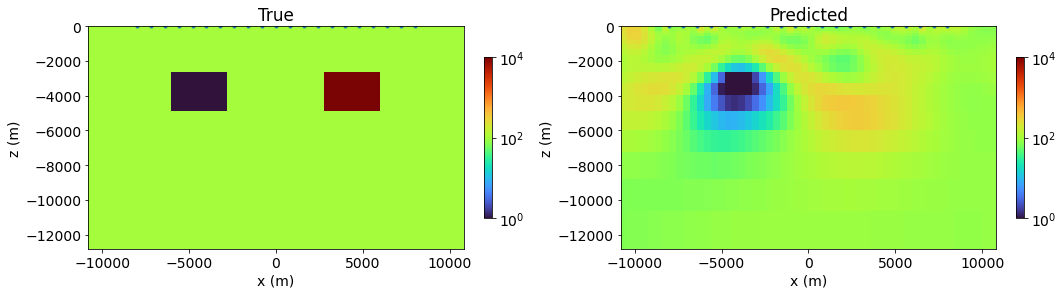

In [194]:
matplotlib.rcParams['font.size'] = 14
fig, axs = plt.subplots(1,2, figsize=(15, 7.5))
ax1, ax2 = axs
out = mesh_core.plot_image(1./sigma[inds_core], grid=False, ax=ax1, pcolor_opts={'norm':LogNorm(vmin=1, vmax=1e4), 'cmap':'turbo'})
plt.colorbar(out[0], fraction=0.02, ax=ax1)
ax1.plot(rx_locs[:,0], rx_locs[:,1], '.')
ax1.set_aspect(1)

out = mesh_core.plot_image(1./sigma_est[inds_core], grid=False, ax=ax2, pcolor_opts={'norm':LogNorm(vmin=1, vmax=1e4), 'cmap':'turbo'})
plt.colorbar(out[0], fraction=0.02, ax=ax2)
ax2.plot(rx_locs[:,0], rx_locs[:,1], '.')
ax2.set_aspect(1)
plt.tight_layout()
titles = ["True","Predicted"]
for ii, ax in enumerate(axs):
    ax.set_xlabel("x (m)")
    ax.set_ylabel("z (m)")
    ax.set_title(titles[ii])